# Notebook to show how to analyse the highschool dataset

In [1]:
import numpy as np
import pandas as pd
import yaml
import networkx as nx
import sklearn
from sklearn import metrics

import tools as tl
import JointCRep
import synthetic

In [4]:
'''
Import network
'''
network = '../data/input/highschool_data.dat'
A, B, B_T, data_T_vals = tl.import_data(network, ego='source', alter='target', undirected=False,
                                        force_dense=False, noselfloop=True, verbose=True, binary=True)
nodes = A[0].nodes()
N = len(nodes)
L = len(A)
K = 4

../data/input/highschool_data.dat shape: (100, 3)
Creating the network ... done!
Removing self loops

Number of nodes = 31
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 100 - <k> = 6.452
Sparsity [0] = 0.104
Reciprocity (networkX) = 0.52
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.351



In [9]:
'''
Run model (it may take 10-20 seconds)
'''
undirected = False
flag_conv = 'log'

# setting to run the algorithm
with open('setting_JointCRep.yaml') as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)
    
conf['out_inference'] = False
conf['plot_loglik'] = False
conf['verbose'] = False
conf['rseed'] = 0
conf['N_real'] = 50
    
mod_jointcrep = JointCRep.joint_crep(N=N, L=L, K=K, undirected=undirected, **conf)
pars_jointcrep = mod_jointcrep.fit(data=B, data_T=B_T, data_T_vals=data_T_vals, flag_conv=flag_conv, nodes=nodes)

Best real = 8 - maxL = -137.49469111286413 - best iterations = 171


### Communities

In [10]:
graph = A[0]

node_size = [graph.degree[i]*10 for i in list(graph.nodes())]
colors = {0: 'indianred', 1: 'mediumseagreen', 2: 'lightskyblue', 3: 'sandybrown'}
pos = nx.spring_layout(graph, k=0.05, iterations=100, seed=20)
edge_color = 'darkgrey'
node_color = '#3b8bc2ff'

In [11]:
u = tl.normalize_nonzero_membership(pars_jointcrep[0])  # out-going mixed-memberships
v = tl.normalize_nonzero_membership(pars_jointcrep[1])  # in-coming mixed-memberships
thetas = {'u': u, 'v': v}
communities = {'u': np.argmax(u, axis=1), 'v': np.argmax(v, axis=1)}  # extract hard-memberships

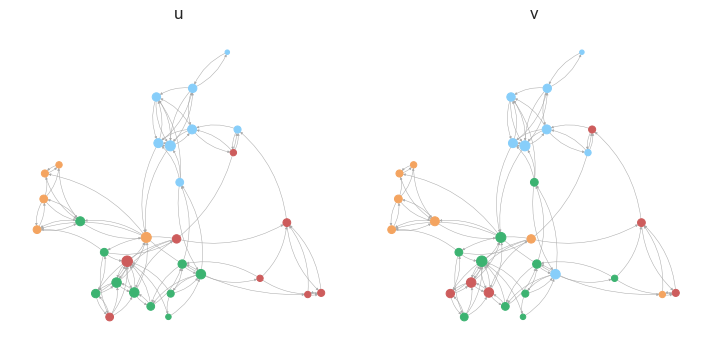

In [12]:
tl.plot_hard_membership(graph, communities, pos, node_size, colors, edge_color)

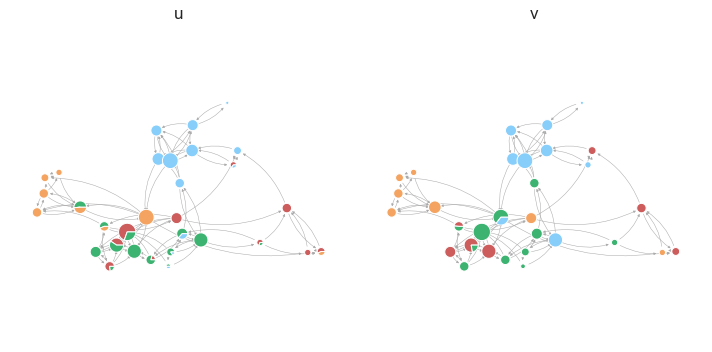

In [13]:
tl.plot_soft_membership(graph, thetas, pos, node_size, colors, edge_color)

### Network reconstruction

In [14]:
Bdense = B.toarray()  # dense representation of the adjacency matrix

U, V, W, eta, maxL = pars_jointcrep  # save the inferred parameters

# compute marginal and conditional expected value
M_marginal, M_conditional = tl.expected_computation(B=Bdense, U=U, V=V, W=W, eta=eta)

##### Adjacency matrix

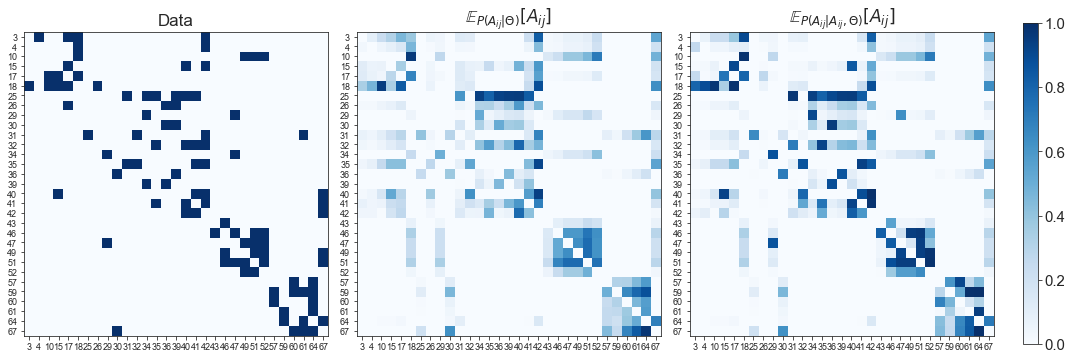

In [15]:
tl.plot_adjacency(Bdense, M_marginal, M_conditional, nodes)

##### NetworkX graph

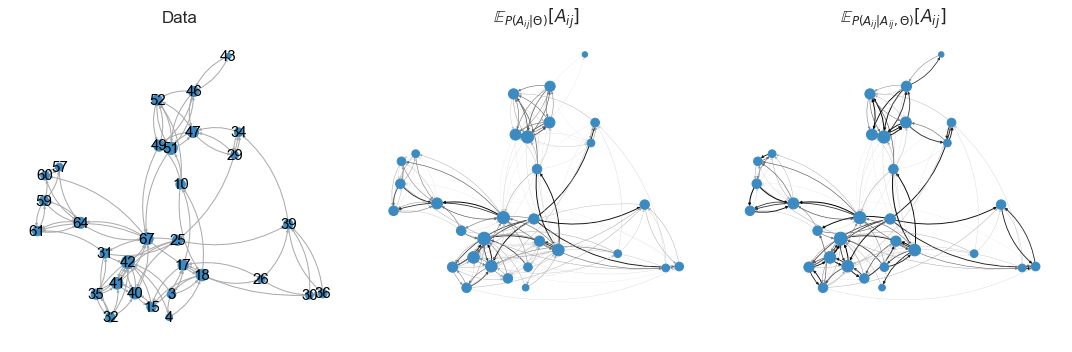

In [16]:
node_size= [graph.degree[i]*15 for i in list(graph.nodes())]
tl.plot_graph(graph, M_marginal, M_conditional, pos, node_size, node_color, edge_color)

##### Precision and recall of the joint distribution

In [17]:
# compute the joint probability for every pair of edges, i.e., the vector of probabilities p=[p00,p01,p10,p11]
p00, p01, p10, p11 = tl.compute_M_joint(U=U, V=V, W=W, eta=eta)

In [18]:
# extract the inferred labels
idx_upper = np.triu_indices(N, k=1)

inf_labels = [(0,0), (0, 1), (1, 0), (1, 1)]
true_labels, pred_labels = [], []

for i, j in zip(*idx_upper):
    true_labels.append(inf_labels.index((int(Bdense[0, i, j]), int(Bdense[0, j, i]))))
    probs = [p00[0, i, j], p01[0, i, j], p10[0, i, j], p11[0, i, j]]
    probs /= sum(probs)
    pred_labels.append(np.argmax(probs))

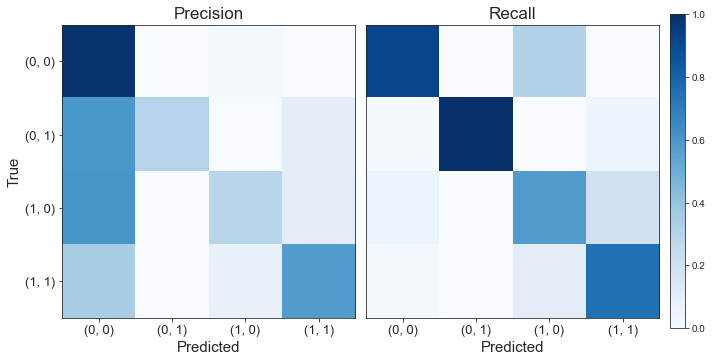

In [19]:
# compute the confusion matrix between true and predicted labels and plot precision and recall
conf_matrix = sklearn.metrics.confusion_matrix(true_labels, pred_labels)
tl.plot_precision_recall(conf_matrix)

### Sampled networks

In [20]:
degrees = [graph.degree(n) for n in graph.nodes()]
k = np.mean(degrees)

In [21]:
# generate five samples with different random seeds
Bsampled = []
np.random.seed(17)
rseed = np.random.randint(18)

for i in range(5):
    syn = synthetic.ReciprocityMMSBM_joints(N=N, K=K, avg_degree=k, show_details=True, show_plots=False,
                                      eta=eta, parameters=[U, V, W], seed=rseed, output_net=False)
    Bsampled.append(syn.layer_graphs[0].toarray())
    
    rseed += np.random.randint(1,18)

Number of nodes = 31
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 86 - <k> = 5.548
Sparsity [0] = 0.089
Reciprocity (networkX) = 0.395
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.246
Number of nodes = 31
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 93 - <k> = 6.0
Sparsity [0] = 0.097
Reciprocity (networkX) = 0.538
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.368
Number of nodes = 31
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 99 - <k> = 6.387
Sparsity [0] = 0.103
Reciprocity (networkX) = 0.444
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.286
Number of nodes = 30
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 82 - <k> = 5.467
Sparsity [0] = 0.091
Reciprocity (networkX) = 0.463
Reciprocity (intended as the proport

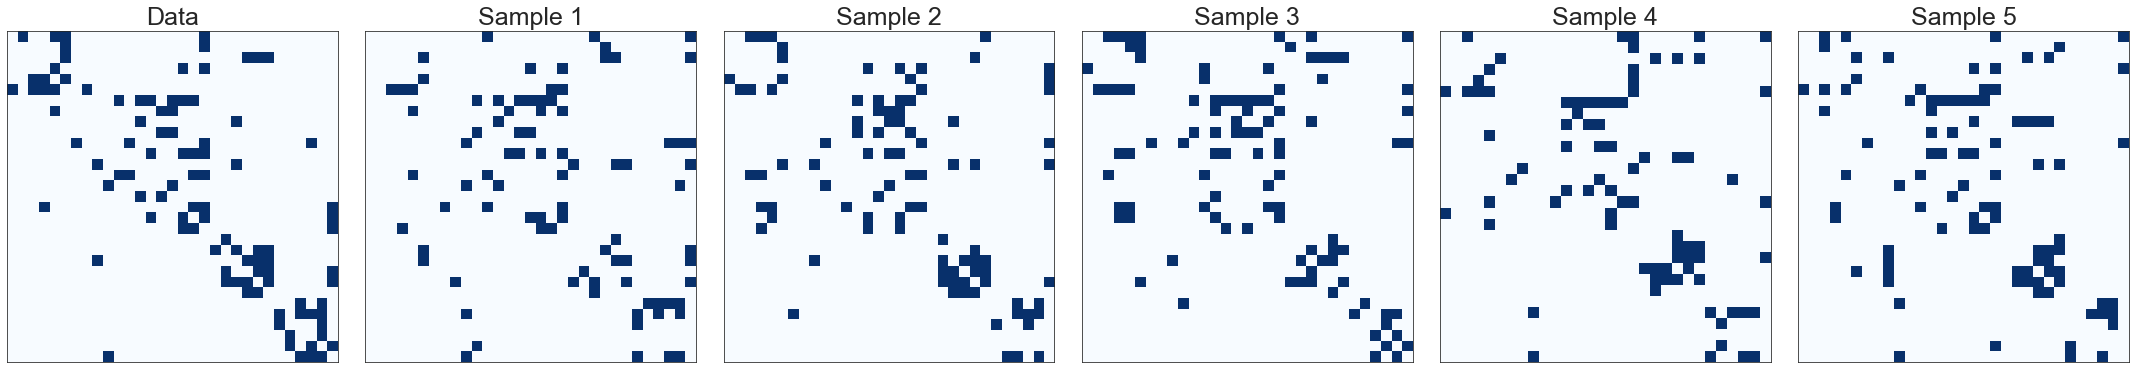

In [22]:
tl.plot_adjacency_samples(Bdense, Bsampled)